In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from tqdm import trange
import pandas as pd
pd.set_option('expand_frame_repr', False)
from matplotlib.ticker import FormatStrFormatter  
sns.set(font_scale=2)
import sys
import json
import os
import re
from scipy.stats import pearsonr
import pickle

## Util

In [2]:
dataset_name = ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Traffic', 'Electricity','ILI', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']
datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','illness_ltsf','sunspot', 'solar_hour', 'solar_10min','river_flow']
def replace_dataset_name(df):
    df['dataset'] = df['dataset'].replace('ettm1', 'ETTm1', regex=True) 
    df['dataset'] = df['dataset'].replace('ettm2', 'ETTm2', regex=True) 
    df['dataset'] = df['dataset'].replace('etth1', 'ETTh1', regex=True) 
    df['dataset'] = df['dataset'].replace('etth2', 'ETTh2', regex=True) 
    df['dataset'] = df['dataset'].replace('exchange_ltsf', 'Exchange', regex=True) 
    df['dataset'] = df['dataset'].replace('weather_ltsf', 'Weather', regex=True) 
    df['dataset'] = df['dataset'].replace('traffic_ltsf', 'Traffic', regex=True) 
    df['dataset'] = df['dataset'].replace('electricity_ltsf', 'Electricity', regex=True) 
    df['dataset'] = df['dataset'].replace('illness_ltsf', 'ILI', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_hour', 'Solar Hour', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_10min', 'Solar 10min', regex=True) 
    df['dataset'] = df['dataset'].replace('river_flow', 'River Flow', regex=True) 
    df['dataset'] = df['dataset'].replace('sunspot', 'Sunspot', regex=True) 
    df['dataset'] = df['dataset'].replace('exchange_rate_nips', 'Exchange Rate', regex=True) 
    df['dataset'] = df['dataset'].replace('solar_nips', 'Solar', regex=True) 
    df['dataset'] = df['dataset'].replace('electricity_nips', 'Electricity', regex=True) 
    df['dataset'] = df['dataset'].replace('traffic_nips', 'Traffic', regex=True)  
    df['dataset'] = df['dataset'].replace('wiki2000_nips', 'Wikipedia', regex=True)
    return df

def sort_order(cat_res, sort_order_dict=None, inf_sort_order=False):
    # cat_res = cat_res.loc[cat_res['Infer hor.'] != '24']
    
    # inf_sort_order = ['48', '60', '96', '192', '336', '720', '1024']
    if inf_sort_order:
        inf_sort_order = ['24', '48', '96', '192','336', '720', '1024']
        cat_res['Infer hor.'] = pd.Categorical(cat_res['Infer hor.'], categories=inf_sort_order, ordered=True)
        cat_res = cat_res.sort_values(by='Infer hor.')
    
    if sort_order_dict is not None:
        for key, value in sort_order_dict.items():
            cat_res[key] = pd.Categorical(cat_res[key], categories=value, ordered=True)
            cat_res = cat_res.sort_values(by=key)
    
    return cat_res

def filed_filter(df, fileds_dict, eq=True):
    for key, values in fileds_dict.items():
        if eq:
            df = df[df[key].isin(values)]
        else:
            df = df[~df[key].isin(values)]
                
    return df

def add_spec_setting(res_dict, prefix=''):
    datasets = []
    infer_hor = []
    train_hor = []
    val_hor = []
    ND = []
    NRMSE = []
    seed = []
    for dataset in ['ETTm1','ETTm2','ETTh1','ETTh2','Exchange','Weather', 'Electricity','Traffic', 'Solar Hour', 'Solar 10min', 'River Flow', 'Sunspot']:
        for hor in ['96', '192', '336', '720']:
            try: 
                ND.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['ND'].values[0])
                NRMSE.append(res_dict[(res_dict['val_len']==hor) & (res_dict['Infer hor.']==hor) & (res_dict['Train hor.']==hor) & (res_dict['dataset']==dataset)]['NRMSE'].values[0])
                datasets.append(dataset)
                infer_hor.append(hor)
                train_hor.append(prefix+'spec')
                val_hor.append(prefix+'spec')
                seed.append(0)
            except:
                continue
            
    res_dict = {"dataset": datasets, "Infer hor.": infer_hor, "Train hor.": train_hor, "val_len": val_hor, "ND": ND , "NRMSE": NRMSE, "seeds": seed,}
    return pd.DataFrame(res_dict)

def plot_multi_marked_line(res,  x,  y, hue=None, style=None, title=None, datasets=['ETTh1'],save_name=None,line_styles=False, 
                           line_style_list=None,errorbar=None, palette=None, data_char=None, axvline=None,axhline=None, axhline_label=None,
                           hight=5, width=6, x_min=None, x_max=None, all_in_one=False, font_scale=1.5):
    sns.set(font_scale=font_scale)
    sub_num = len(datasets)
    if palette:
        sns.set_palette(palette)
    if sub_num > 1 and not all_in_one:
        plt.figure()
        total_len = sub_num * width
        fig, ax = plt.subplots(1, sub_num,figsize=(total_len, hight))  
        legend = False
        for i in range(sub_num):
            if line_style_list is not None:
                local_line_style = line_style_list[i]
            else:
                local_line_style = line_styles
                
            if datasets[i] == 'ETT':
                sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
            else:
                sub_res = res[res['dataset']==datasets[i]]
                
            if i == (sub_num-1):
                legend = True
            sns.lineplot(
                data=sub_res, legend=legend,
                x=x, y=y, hue=hue, style=style, ax=ax[i], errorbar=errorbar,
                markers=True, dashes=local_line_style, linewidth=2,markersize=10
            )
            if axvline is not None:
                ax[i].axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            
            if data_char is not None:
                season = data_char[datasets[i]]['Seasonality']
                trend = data_char[datasets[i]]['Trend']
                data_char_str = f'\nFs:{season} Ft:{trend}'
            else:
                data_char_str = ''
            ax[i].set_title(f'{datasets[i]}{data_char_str}')  
            ax[i].tick_params(axis='y', labelsize=15)    
            ax[i].tick_params(axis='x', labelsize=16)    
            if i > 0:
                ax[i].set_ylabel('')
                
        if title is not None:
            fig.suptitle(title)
    else:
        plt.figure(figsize=(width, hight))
        if datasets[0] == 'ETT':
            sub_res = res[(res['dataset']=='ETTm1') | (res['dataset']=='ETTm2') | (res['dataset']=='ETTh1') | (res['dataset']=='ETTh2')]
        else:
            # sub_res = res[res['dataset']==datasets[0]]
            sub_res = res[res['dataset'].isin(datasets)]
        sns.lineplot(
            data=sub_res,
            x=x, 
            y=y, 
            hue=hue, style=style, errorbar=None,
            markers=True, dashes=line_styles, linewidth=2, markersize=10
        )
        if axvline is not None:
            plt.axvline(x=axvline, color='r', linestyle='--', linewidth=2,markersize=10) 
            
        if axhline is not None:
            plt.axhline(y=axhline, color='gray', linestyle='--', linewidth=2, label=axhline_label)
        
        if x_min is not None:
            plt.xlim(x_min, x_max)
            
        if title is not None:
            plt.title(title)
    
    # plt.legend(title=hue, loc='upper left', bbox_to_anchor=(1, 1))  
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title=hue)  
    plt.tight_layout() 
    if save_name is not None:
        plt.savefig(f'fig/{save_name}.svg', format='svg') 

## Load data

In [3]:
def load_result(root_dir, verbose=True, models=['PatchTST'], train_pred_len_list=['24','36','48','60','96','192','336','720'], train_context_list=['36','96'], datasets=None):
    NRMSE = []
    ND = []
    CRPS = []
    train_pred_len_lists = []
    dataset_list = []
    seeds = []
    train_ctx = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    csv_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/test/metrics.csv"
                    try:
                        data = pd.read_csv(csv_file)
                    except:
                        if verbose:
                            print("cannot find ", csv_file) 
                        continue
                    
                    for idx in range(len(data)):
                        NRMSE.append(data['test_NRMSE'][idx])
                        ND.append(data['test_ND'][idx])
                        CRPS.append(data['test_CRPS'][idx])

                        dataset_list.append(dataset)
                        model_str = model
                        train_pred_len_lists.append(train_pred_len)
                        train_ctx.append(train_context)
                        model_list.append(model_str)
                        seeds.append(seed)

    res_dict = {"dataset": dataset_list, "pred hor.": train_pred_len_lists, "ND":ND , "NRMSE": NRMSE, 'CRPS':CRPS, "seeds": seeds,
                "model": model_list,'train_ctx': train_ctx}

    return pd.DataFrame(res_dict)


# ReVIN

## long

In [4]:
# PatchTST

datasets=None
root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_false_res['scaling'] = 'false'
norm_false_res['revin'] = 'false'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_true_res['scaling'] = 'false'
norm_true_res['revin'] = 'true'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['PatchTST'], datasets=datasets) 
norm_temp_res['scaling'] = 'true'
norm_temp_res['revin'] = 'false'

patchtst_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)
patchtst_res['scaler'] = 'standard'

In [5]:
def get_df_results(root_path, models,datasets=None,verbose=False):
    combined_df = pd.DataFrame()
    # if datasets is None:
    #     datasets = ['etth1','''exchange_ltsf','weather_ltsf','traffic_ltsf','electricity_ltsf','illness_ltsf']
    for scaler in ['identity', 'standard']:
        for revin in ['true', 'false']:
            for scaling in ['false', 'true']:
                norm_res = load_result(root_dir = f"{root_path}{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=verbose, models=models, datasets=datasets)
                norm_res['scaler'] = scaler
                norm_res['revin'] = revin
                norm_res['scaling'] = scaling
                combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
    return combined_df

In [6]:
gru_nvp_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRU_NVP'])
csdi_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['CSDI'])
timegrad_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['TimeGrad'])
gru_res = get_df_results('/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/', ['GRUForecaster'])
patchtst_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['PatchTST'])
gru_nvp_ili_res = get_df_results('/home/v-zhangjiaw/Blob_EastUS/v-jiawezhang/log/abl_norm/', ['GRU_NVP'])

combined_df = pd.concat([patchtst_res, patchtst_ili_res, gru_nvp_res, gru_nvp_ili_res, csdi_res, timegrad_res, gru_res], ignore_index=True)
combined_df['model'] = combined_df['model'].replace('GRUForecaster', 'GRU')
combined_df['model'] = combined_df['model'].replace('GRU_NVP', 'GRU NVP')

In [7]:
def reformat(res_dict):
    datasets = []
    pred_hor = []
    norm = []
    ND = []
    CRPS = []
    seed = []
    global_norm = []
    model = []
    for index, row in res_dict.iterrows():
        if row['revin'] == 'true' and row['scaling'] == 'false':
            norm.append('ReVIN')
        elif row['revin'] == 'false' and row['scaling'] == 'true':
            norm.append('Scaling')
        elif row['revin'] == 'false' and row['scaling'] == 'false':
            norm.append('None')
        else:
            continue
        
        datasets.append(row['dataset'])
        pred_hor.append(row['pred hor.'])
        ND.append(row['ND'])
        global_norm.append(row['scaler'])
        CRPS.append(row['CRPS'])
        model.append(row['model'])
        
            
    res_dict = {'model': model, "dataset": datasets, "gobal norm": global_norm, "pred hor.": pred_hor, "CRPS": CRPS, "ND": ND , "norm": norm}
    return pd.DataFrame(res_dict)

In [8]:
norm_res = reformat(combined_df)
norm_res = replace_dataset_name(norm_res)

sort_order_dict = {'pred hor.': ['24','36','48','60','96','192','336','720'], 'model': ['PatchTST', 'CSDI','GRU', 'TimeGrad', 'GRU NVP'], 'norm': ['ReVIN', 'Scaling','None']}
sort_norm_res = sort_order(norm_res, sort_order_dict=sort_order_dict)

In [9]:
# sort_norm_res['CRPS/ND'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.3f}/{x['ND']:.3f}", axis=1)
sort_norm_res['ND'] = sort_norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_norm_res['CRPS'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='standard']

In [10]:
# Create a pivot table
pivot_table_crps = pd.pivot_table(
    sort_norm_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0],
    observed=False
)

pivot_table_nd = pd.pivot_table(
    sort_norm_res,
    values=['ND'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'norm'],
    aggfunc=lambda x: x.iloc[0],
    observed=False
)

def to_markdown(pivot_table):
    pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
    pivot_table = pivot_table.reset_index()
    pivot_table_formatted_md = pivot_table.to_markdown()
    return pivot_table_formatted_md

In [11]:
import re

def mark_best_value(data):
    # 切分数据到行
    lines = data.strip().split('\n')

    # 准备新的表格内容
    new_lines = []
    count = 0
    for line in lines:
        if 'dataset' in line or "tabular" in line or 'rule' in line or 'multicolumn' in line or 'norm' in line:
            new_lines.append(line)  # 添加标题行
            continue
        
        if 'cline' in line:
            continue
        
        pattern = r"\b\d+\.\d{2,4}\b|NaN"
        values = re.findall(pattern, line)

        def mark_values(value_list, marker='bold'):
            
            numeric_values = []
            for v in value_list:
                if v != '-' and v != 'NaN':
                    numeric_values.append(float(v.split('_')[0]))
                else:
                    numeric_values.append(1000)

            # 排序获取索引
            sorted_indices = sorted(range(len(numeric_values)), key=lambda k: numeric_values[k], reverse=False)
            
            # 处理相同最小值的情况
            min_val = numeric_values[sorted_indices[0]]
            min_count = numeric_values.count(min_val)
            
            # 标记最小值
            for i in range(min_count):
                if marker=='bold':
                    value_list[sorted_indices[i]] = r'\bm{' + value_list[sorted_indices[i]] + '}'
                else:
                    value_list[sorted_indices[i]] = r'\underline{' + value_list[sorted_indices[i]] + '}'

            return value_list

        marked_values = [None]*len(values)
        for i in range(0, len(values), 3):
            marked_values[i:i+3] = mark_values(values[i:i+3],marker='bold')
            
        numeric_values = [float(re.search(r'(\d+\.\d+)', v).group(1)) for v in marked_values if re.search(r'(\d+\.\d+)', v)]
        min_value = min(numeric_values)
        
        def add_underline(value, min_value):
            matched_value = re.search(r'(\d+\.\d+)', value)
            if matched_value:
                if float(min_value) == float(matched_value.group(1)):
                    value = r'\underline{' + value + '}'
            return value
        
        updated_values = [add_underline(v, min_value) for v in marked_values]
        
        # 构造新行
        new_line_parts = line.split('&')
        new_line_parts[2:] = [' $' + v + '$' for v in updated_values]
        new_line = ' & '.join(new_line_parts) + ' \\\\ '
        
        new_line = new_line.replace('_{0.', '_{.')
        new_line = new_line.replace('\multirow[t]', '\multirow[c]')
        new_line = new_line.replace('$NaN$', '-')
        new_line = new_line.replace('$\\bm{NaN}$', '-')
        new_lines.append(new_line)
        
        if '&  720  &' in new_line or '&  60  &' in new_line:
            new_lines.append('\midrule')

    # 将新的行合并成最终的表格
    final_table = '\n'.join(new_lines)
    print(final_table)

In [12]:
# print(pivot_table_formatted_md)
pivot_table_crps

CRPS                                                                                                                  
model                 PatchTST                     CSDI                     GRU                 TimeGrad                 GRU NVP                
norm                     ReVIN Scaling    None    ReVIN Scaling    None   ReVIN Scaling    None    ReVIN Scaling    None   ReVIN Scaling    None
dataset     pred hor.                                                                                                                           
ETTh1       96          0.3212  0.3437  0.3447   0.2764  0.3630  0.3671  0.4457  0.9734  0.5090   0.2958  0.6963  0.5434  0.2771  0.5946  0.4444
            192         0.3562  0.3943  0.3785   0.3553  0.4352  0.4673  0.4763  1.0658  0.5915   0.3119  0.6410  0.5698  0.3076  0.4729  0.5056
            336         0.3737  0.4213  0.4099   0.3614  0.4192  0.4814  0.4998  1.1416  0.5956   0.3950  0.6586  0.6192  0.3081  0.6240  0.4803
            720         0.3909  0.4881  0.4648   0.3960  0.4283  0.5609  0.5901  1.2715  0.7265   0.3435  0.8670  0.5837  0.3641  0.7295  0.5862
ETTh2       96          0.1763  0.1900  0.1892   0.1446  0.1590  0.1681  0.2913  0.5277  0.8732   0.1600  0.3530  0.6846  0.1866  0.4399  0.4061
            192         0.2012  0.2167  0.2189   0.1734  0.1983  0.2078  0.3334  0.5329  0.9771   0.1905     NaN  0.6518  0.1894  0.5601  0.4510
            336         0.2244  0.2446  0.2446   0.2094  0.2124  0.2728  0.3658  0.5879  0.7353   0.2205  0.4272  0.6447  0.2379  0.4289  0.6722
            720         0.2301  0.2829  0.2819   0.2054  0.2512  0.3062  0.3594  0.6519  1.0921   0.2198     NaN     NaN  0.2560  0.4629  0.9457
ETTm1       96          0.2649  0.2858  0.2989   0.2255  0.2597  0.2569  0.4411  0.9213  0.4433   0.2888  0.4271  0.5373  0.3132  0.5557  0.3964
            192         0.2925  0.3077  0.3349   0.3313  0.3495  0.3280  0.4824  0.9978  0.6205   0.2975     NaN     NaN  0.3313  0.5342  0.5106
            336         0.3107  0.3338  0.3618      NaN  0.4120  0.3663  0.4879  1.0089  0.6186      NaN     NaN     NaN  0.3296  0.5614  0.4604
            720         0.3468  0.3780  0.3790   0.3789  0.4367  0.3933  0.4941  1.0310  0.7808      NaN     NaN     NaN  0.3520  0.5568  0.4383
ETTm2       96          0.1335  0.1587  0.1522   0.1134  0.1340  0.1314  0.1802  0.4339  0.4133   0.1206  0.2376  0.4493  0.1150  0.4053  0.4107
            192         0.1601  0.1940  0.1884   0.1386  0.1583  0.1391  0.2074  0.4159  0.5699   0.1399     NaN     NaN  0.1363  0.4170  0.4690
            336         0.1798  0.2249  0.1994   0.1592  0.1782  0.2139  0.2216  0.4764  0.7246      NaN     NaN     NaN  0.1571  0.4050  0.4163
            720         0.2063  0.2905  0.2940   0.1892  0.2002  0.2218  0.3022  0.5101  0.6574      NaN     NaN     NaN  0.1801  0.5590  0.3968
Electricity 96          0.0857  0.0867  0.0848   0.0761  0.0735  0.0735  0.2261  0.1462  0.1218   0.0771  0.0904  0.0961  0.0805  0.0882  0.0923
            192         0.0912  0.0918  0.0910   0.2749  0.2584  0.2475  0.2381  0.1851  0.1299   0.0806  0.0936  0.0980  0.0833  0.0945  0.0935
            336         0.1001  0.1005  0.1006   0.2153  0.2835  0.3136  0.2807  0.2405  0.1364   0.0905  0.1002  0.1125  0.0925  0.0932  0.0982
            720         0.1160  0.1187  0.1178  25.7527  0.2945  0.2667  0.3228  0.2340  0.1455   0.1164  0.0957  0.1096  0.1107  0.1036  0.1065
Exchange    96          0.0235  0.0254  0.0299   0.0216  0.0210  0.0343  0.0385  0.1539  0.0737   0.0279  0.0478  0.0837  0.0246  0.0559  0.0605
            192         0.0336  0.0365  0.0404   0.0383  0.0388  0.0418  0.0486  0.1704  0.0858   0.0364  0.0743  0.0638  0.0340  0.0814  0.0860
            336         0.0462  0.0532  0.0597   0.0508  0.0485  0.0510  0.0630  0.2240  0.0778   0.0510  0.1142  0.1030  0.0475  0.0948  0.0637
            720         0.0777  0.0810  0.0824   0.0881  0.1042  0.0964  0.0955  0.3978  0.0987   0.0800  0.142

In [15]:
# latex_code = pivot_table.to_latex(multicolumn=True, multirow=True)

In [16]:
# mark_best_value(latex_code)

## Plot scatter

### Trend & Seasonality

In [23]:
data_char = pd.read_csv("./exp_res/data_char.csv",index_col='Data Characteristic')
custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }
auto_dict = {}

for model in ['iTransformer', 'DLinear','PatchTST',	'GRU NVP','TimeGrad','CSDI','GRU']:
    if model in ['GRU NVP','TimeGrad','GRU']:
        type = 'AR'
    else:
        type = 'NAR'

    auto_dict.update({model: type})

def get_norm_res_dict(pivot_table,metrics='CRPS'):
    custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }
    
    datasets = []
    horizons = []
    models = []
    score_gap_list = []
    dec_scheme = []
    score = []
    seasonality = []
    trend = []
    norms = []
    non_gaussian = []
    for model in ['CSDI','PatchTST', 'TimeGrad','GRU NVP', 'GRU']:
        for norm in ['ReVIN', 'Scaling', 'None']:
            for idx in pivot_table.index:
                if pivot_table[metrics][model][norm][idx] == 'NaN':
                    continue
                score_gap = float(pivot_table[metrics][model]['None'][idx]) - float(pivot_table[metrics][model][norm][idx])
                datasets.append(idx[0])
                horizons.append(idx[1])
                models.append(model)
                seasonality.append(data_char.loc['Seasonality'][idx[0]+'-L'])
                trend.append(data_char.loc['Trend'][idx[0]+'-L'])
                non_gaussian.append(data_char.loc['JS Div.'][idx[0]+'-L'])
                score.append(float(pivot_table[metrics][model][norm][idx]))
                norms.append(norm)
                if model in ['TimeGrad','GRU NVP', 'GRU']:
                    dec_scheme.append('AR')
                else:
                    dec_scheme.append('NAR')
                score_gap_list.append(score_gap)
            
    score_gap_dict = {'dataset': datasets, 'Gap': score_gap_list, 'Horizon': horizons, 'Model': models, 'Type': dec_scheme, metrics: score, 'Seasonality': seasonality, 'Trend': trend, 'Non-Gaussianity': non_gaussian, 'norm': norms}

    gap_pd = pd.DataFrame(score_gap_dict)
    return gap_pd
    

In [28]:
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_norm_scatter(gap_dict, x, y, hue=None, style=None, size=None, title=None, hight=5, width=6):
    plt.figure(figsize=(width, hight))
    
    g = sns.scatterplot(data=gap_dict, x=x, y=y, hue=hue, style=style, size=size, palette="coolwarm", sizes=(40, 1000),hue_norm=(-0.5, 0.5))
    
    # 获取legend句柄和标签
    handles, labels = g.get_legend_handles_labels()

    # 将标签格式化为小数点后两位
    new_labels = [f"{float(label):.2f}" if label.replace('.', '', 1).replace('-', '', 1).isdigit() else label for label in labels]

    # 重新设置legend
    lg = g.legend(handles, new_labels, title='CRPS Gap', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.setp(lg.get_title(), fontweight='bold')
    plt.tight_layout() 
    if title is not None:
        plt.title(title)

    plt.show()
    
    
def plot_multi_norm_scatter(gap_dict, x, y, hue=None, style=None, size=None, hight=5, width=6, models=['TimeGrad', 'GRU', 'CSDI','PatchTST'],title=None,hue_norm=(-0.5, 0.5), legend_title='CRPS Gain'):
    
    width = len(models) * width
    # 创建一个2x2的子图
    fig, axes = plt.subplots(1, len(models), figsize=(width, hight), sharey=True)

    # 绘制每个子图
    g_list = []
    
    for idx, model in enumerate(models):
        local_gap_res = gap_dict[gap_dict['Model']==model]
        # g = scatterplot(local_gap_res, x='Trend', y='Seasonality', hue='Gap', size='Gap', title=model)
        # g = sns.scatterplot(data=local_gap_res, x=x, y=y, hue=hue, style=style, size=size, palette="coolwarm", sizes=(40, 1000),hue_norm=hue_norm, ax=axes[idx])
        g = sns.scatterplot(data=local_gap_res, x=x, y=y, hue=hue, style=style, size=local_gap_res[hue].abs(), palette="coolwarm", sizes=(40, 1000),hue_norm=hue_norm, ax=axes[idx])
        axes[idx].set_title(model)  
        g_list.append(g)
        
    target_g = len(axes) - 1
    
    # 删除除最后一个子图之外的所有图例
    for idx, ax in enumerate(axes):
        if idx != target_g:
            ax.get_legend().remove()
    

    # 获取legend句柄和标签
    handles, labels = g_list[target_g].get_legend_handles_labels()

    # 将标签格式化为小数点后两位
    new_labels = [f"{float(label):.2f}" if label.replace('.', '', 1).replace('-', '', 1).isdigit() else label for label in labels]

    # 重新设置legend
    lg = g_list[target_g].legend(handles, new_labels, title=legend_title, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.setp(lg.get_title(), fontweight='bold')
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

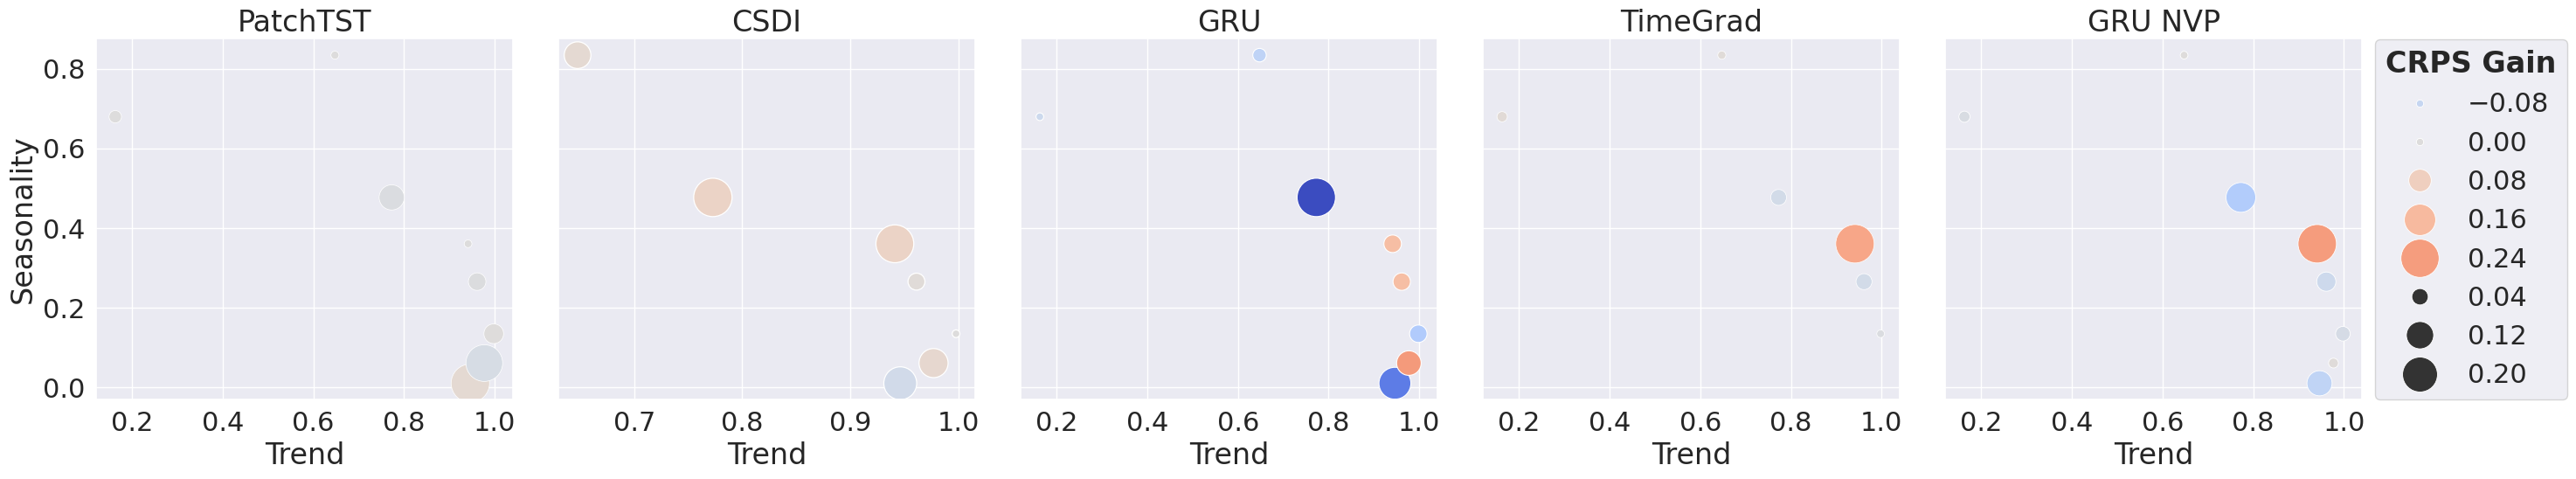

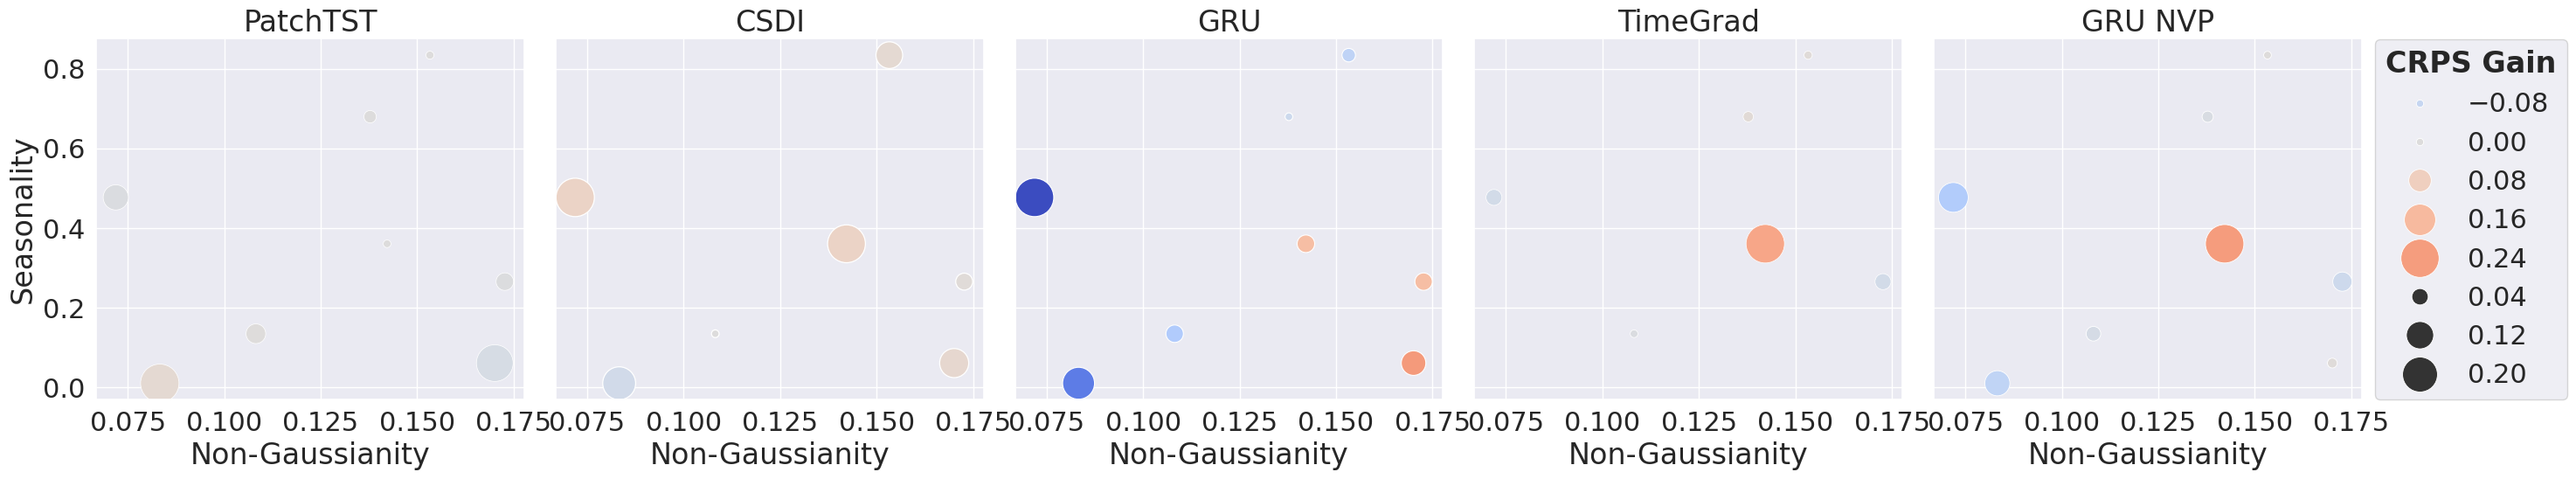

In [34]:
# gap_res = gap_res[gap_res['dataset']!='Traffic']

# gap_res = get_norm_res_dict(pivot_table_crps,metrics='CRPS')
# gap_res = gap_res[gap_res['Horizon']=='336']
# gap_res = gap_res[gap_res['norm']=='ReVIN']
# plot_multi_norm_scatter(gap_res, x='Trend', y='Seasonality', hue='Gap', size='Gap', hight=6, width=6, models=['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP'],legend_title='CRPS Gain')
# plot_multi_norm_scatter(gap_res, x='Non-Gaussianity', y='Seasonality', hue='Gap', size='Gap', hight=6, width=6, models=['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP'],legend_title='CRPS Gain')


gap_res = get_norm_res_dict(pivot_table_crps,metrics='CRPS')
gap_res = gap_res[gap_res['Horizon']=='336']
gap_res = gap_res[gap_res['norm']=='Scaling']
plot_multi_norm_scatter(gap_res, x='Trend', y='Seasonality', hue='Gap', size='Gap', hight=6, width=6, models=['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP'],hue_norm=(-0.5, 0.5),legend_title='CRPS Gain')
plot_multi_norm_scatter(gap_res, x='Non-Gaussianity', y='Seasonality', hue='Gap', size='Gap', hight=6, width=6, models=['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP'],hue_norm=(-0.5, 0.5),legend_title='CRPS Gain')

In [ ]:
# timegrad_gap_res = gap_res[gap_res['Model']=='TimeGrad']
# plot_norm_scatter(timegrad_gap_res, x='Trend', y='Seasonality', hue='Gap', size='Gap', hight=5, width=8, title='TimeGrad')

In [35]:
def get_mean_res_dict(long_crps):
    season = []
    trend = []
    crps=[]
    models=[]
    type=[]
    datasets = []
    pred_len=[]
    norm_crps = []

    for idx in long_crps.index:
        model = long_crps.loc[idx]['Model']
        season.append(long_crps.loc[idx]['Seasonality'])
        trend.append(long_crps.loc[idx]['Trend'])
        datasets.append(long_crps.loc[idx]['dataset'])
        crps.append(long_crps.loc[idx]['CRPS'])
        models.append(model)
        type.append(auto_dict[model])
        # pred_len.append(long_crps['Forecasting Horizon'][idx])
            

    df = {'Trend': trend, 'Seasonality': season, 'CRPS': crps, 'Model': models, 'Type': type, 'dataset': datasets } # 'pred_len':pred_len, 'norm_crps': norm_crps}
    return pd.DataFrame(df)

def plot_scatter(gap_dict, max_y=0.62, dataset='Weather', title=None):
    custom_palette = {
        "NAR": (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),  # 蓝色
        "AR": (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),  # 橙色
    }

    # fig, (ax11, ax12, ax21, ax22) = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios':[1,1,0.4,1.6]})  # 调整大小
    fig, (ax11, ax12, ax22) = plt.subplots(1, 3, figsize=(22, 6), gridspec_kw={'width_ratios':[1,1,2]})  # 调整大小

    model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 
    # g = sns.scatterplot(data=df_horizon, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, palette=custom_palette, ax=ax1)

    # 手动调整 ax11 和 ax12 位置，使它们更靠近
    pos1 = ax11.get_position()  # 获取 ax11 的位置
    pos2 = ax12.get_position()  # 获取 ax12 的位置

    # 调整 ax11 和 ax12 的 x 位置
    ax11.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    ax12.set_position([pos1.x0 + pos1.width * 1.02, pos2.y0, pos2.width * 1.02, pos2.height])
    
    
    hor_res = gap_dict[(gap_dict['dataset']=='ILI') | (gap_dict['dataset']==dataset)]

    # 绘制第一个区间：0-100
    sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                    style="Model", s=300, palette=custom_palette, ax=ax11)

    ax11.set_xlim(20, 65)
    ax11.set_ylim(0, max_y)
    ax11.set_xticks([24, 36, 48, 60])

    # 在 ax11 和 ax12 之间添加分割符号 "//"
    fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

    # 绘制第二个区间：100-720
    sns.scatterplot(data=hor_res[hor_res['Forecasting Horizon'] > 75], x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                    style="Model", s=300, palette=custom_palette, ax=ax12)

    ax12.set_xlim(70, 770)
    ax12.set_ylim(0, max_y)
    ax12.set_xticks([96, 192, 336, 720])

    ax11.legend().remove()
    ax12.legend().remove()
    # remove y-axis label
    ax12.set_ylabel('')
    ax12.set_yticklabels([])

    # 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
    ax12.set_xlabel('')
    ax11.set_xlabel('')
    fig.text((pos1.x1 + pos2.x0)/2 - 0.0155, pos1.y0 - 0.14, 'Forecast Horizon', ha='center', va='bottom', fontsize=24)

    # gap_dict.replace('-', np.nan, inplace=True)
    gap_dict.replace('NaN', np.nan, inplace=True)
    gap_dict = gap_dict.apply(pd.to_numeric, errors='ignore')

    # grouped_df = gap_dict.groupby(['Model', 'Forecasting Horizon']).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean'}).reset_index()
    grouped_df = gap_dict.groupby(['Model','dataset'],observed=False).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean'}).reset_index()


    # return grouped_df
    # df = get_gap_dict(grouped_df, metrics='CRPS')
    df = get_mean_res_dict(grouped_df)

    # 获取unique的数据集及其对应的trend
    unique_trends = df[['Trend', 'dataset']].drop_duplicates().reset_index(drop=True)
    unique_trends = unique_trends.sort_values(by='Trend')
    unique_trends['Trend Order'] = range(len(unique_trends))


    ch = 'Trend'

    # # 手动调整 ax11 和 ax12 位置，使它们更靠近
    # pos1 = ax21.get_position()  # 获取 ax11 的位置
    # pos2 = ax22.get_position()  # 获取 ax12 的位置

    # # 调整 ax11 和 ax12 的 x 位置
    # ax21.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    # ax22.set_position([pos1.x0 + pos1.width * 1.05, pos2.y0, pos2.width * 1.05, pos2.height])

    # # 绘制第一个区间：0-100
    # sns.scatterplot(data=df, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax21)

    # ax21.set_xlim(0.1, 0.2)
    # ax21.set_ylim(0, max_y)
    # ax21.set_xticks([0.163])
    # ax21.set_xticklabels(['0.16'])

    # # 在 ax11 和 ax12 之间添加分割符号 "//"
    # fig.text((pos1.x1 + pos2.x0)/2 - 0.016, pos1.y0 - 0.02, '//', ha='center', va='bottom', fontsize=22)

    # # 绘制第二个区间：100-720
    
    df[ch] = df[ch].round(2).astype(str)
    
    sort_order_dict = {'Model': ['PatchTST', 'CSDI', 'GRU', 'TimeGrad','GRU NVP']}
    df_sorted = sort_order(df, sort_order_dict=sort_order_dict)
    df_sorted = df_sorted.sort_values(by=[ch, 'Model'])
    
    sns.scatterplot(data=df_sorted, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300, ax=ax22)

    # ax22.set_xlim(0.62, 1.02)
    ax22.set_ylim(0, max_y)
    # ax22.set_xticks([96, 192, 336, 720])

    # ax21.legend().remove()
    ax22.legend().remove()
    # remove y-axis label
    # ax22.set_ylabel('')
    ax22.set_yticklabels([])

    # 删除 ax12 的 x 轴标签（因为我们要在中间添加一个居中的标签）
    # ax22.set_xlabel('')
    # ax21.set_xlabel('')
    # fig.text((pos1.x1 + pos2.x0)/2 + 0.09, pos1.y0 - 0.14, 'Trend', ha='center', va='bottom', fontsize=24)

    hdls, labels = plt.gca().get_legend_handles_labels()
    for i in range(4, 6):
        hdls[i].set_markerfacecolor(custom_palette['NAR'])
    for i in range(6, 8):
        hdls[i].set_markerfacecolor(custom_palette['AR'])

    legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
    for t in legend.get_texts():
        if t.get_text() in ['Type', 'Model']:
            t.set_weight('bold')
    # legend.get_frame().set_facecolor('white')

    # 保存图像
    # plt.savefig('./fig/crps_horizon_and_trend_0814.pdf', bbox_inches='tight')

    if title is not None:
        # plt.title(title)
        fig.suptitle(title, fontsize=24)
        
    # 显示图像
    plt.show()

In [41]:
def plot_trend_scatter(gap_dict, max_y=0.62, width=8, hight=6, title=None, ch='Trend'):
    model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 
    plt.figure(figsize=(width, hight))
    
    gap_dict.replace('NaN', np.nan, inplace=True)
    gap_dict = gap_dict.apply(pd.to_numeric, errors='ignore')

    grouped_df = gap_dict.groupby(['Model','dataset'],observed=False).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean', 'Non-Gaussianity': 'mean'}).reset_index()

    df = get_mean_res_dict(grouped_df)

    # 获取unique的数据集及其对应的trend
    unique_trends = df[[ch, 'dataset']].drop_duplicates().reset_index(drop=True)
    unique_trends = unique_trends.sort_values(by=ch)
    unique_trends['Order'] = range(len(unique_trends))

    df[ch] = df[ch].round(2).astype(str)
    
    sort_order_dict = {'Model': ['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP']}
    df_sorted = sort_order(df, sort_order_dict=sort_order_dict)
    df_sorted = df_sorted.sort_values(by=[ch, 'Model'])
    
    sns.scatterplot(data=df_sorted, x=ch, y='CRPS', hue="Type", markers=model_markers, style="Model",s=300)

    hdls, labels = plt.gca().get_legend_handles_labels()
    for i in range(4, 6):
        hdls[i].set_markerfacecolor(custom_palette['NAR'])
    for i in range(6, 8):
        hdls[i].set_markerfacecolor(custom_palette['AR'])

    legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
    for t in legend.get_texts():
        if t.get_text() in ['Type', 'Model']:
            t.set_weight('bold')

    # 保存图像
    # plt.savefig('./fig/crps_horizon_and_trend_0814.pdf', bbox_inches='tight')

    if title is not None:
        # plt.title(title)
        plt.suptitle(title, fontsize=24)
        
    # 显示图像
    plt.show()
    
def plot_multi_trend_scatter(gap_dict, max_y=0.62, width=8, hight=6, title=None, target_hor='mean',norms=['ReVIN', 'None'],ch='Trend',labelsize=8,metric='CRPS'):
    model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 
    width = len(norms) * width
    # 创建一个2x2的子图
    fig, axes = plt.subplots(1, len(norms), figsize=(width, hight), sharey=True)
    
    def get_mean_res(local_gap_dict):
        local_gap_dict.replace('NaN', np.nan, inplace=True)
        local_gap_dict = local_gap_dict.apply(pd.to_numeric, errors='ignore')

        grouped_df = local_gap_dict.groupby(['Model','dataset'],observed=False).agg({'Gap': 'mean', 'CRPS': 'mean', 'Seasonality': 'mean', 'Trend': 'mean', 'Non-Gaussianity': 'mean'}).reset_index()

        df = get_mean_res_dict(grouped_df)

        return df
    
    def get_trend_info(df, ch='Trend'):
        # 获取unique的数据集及其对应的trend
        unique_trends = df[[ch, 'dataset']].drop_duplicates().reset_index(drop=True)
        unique_trends = unique_trends.sort_values(by=ch)
        unique_trends['Order'] = range(len(unique_trends))
        
        df[ch] = df[ch].round(2).astype(str)
        
        sort_order_dict = {'Model': ['PatchTST', 'CSDI', 'GRU', 'TimeGrad', 'GRU NVP']}
        df_sorted = sort_order(df, sort_order_dict=sort_order_dict)
        df_sorted = df_sorted.sort_values(by=[ch, 'Model'])
        return df_sorted
    
    # 绘制每个子图
    
    for idx, norm in enumerate(norms):
        none_gap_dict = gap_dict[gap_dict['norm']==norm]
        
        if target_hor == 'mean':
            none_gap_dict = get_mean_res(none_gap_dict)
        else:
            none_gap_dict = none_gap_dict[none_gap_dict['Forecasting Horizon']==target_hor]
            
        none_gap_dict = get_trend_info(none_gap_dict,ch=ch)
        g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])
        axes[idx].set_title(norm)  
        axes[idx].tick_params(axis='x', labelsize=labelsize)


    # 删除除最后一个子图之外的所有图例
    for ax in axes[:-1]:
        ax.get_legend().remove()

    # 获取legend句柄和标签
    hdls, labels = g.get_legend_handles_labels()

    for i in range(4, 6):
        hdls[i].set_markerfacecolor(custom_palette['NAR'])
    for i in range(6, 9):
        hdls[i].set_markerfacecolor(custom_palette['AR'])

    legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
    for t in legend.get_texts():
        if t.get_text() in ['Type', 'Model']:
            t.set_weight('bold')

    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

In [43]:
gap_dict = get_norm_res_dict(pivot_table_crps,metrics='CRPS')
# gap_dict = get_norm_res_dict(pivot_table_nd,metrics='ND')
sort_order_dict = {'Horizon': ['24','36','48','60','96','192','336','720'], 'Model': ['PatchTST', 'CSDI', 'GRU', 'TimeGrad','GRU NVP']}
sort_norm_res = sort_order(gap_dict, sort_order_dict=sort_order_dict)
sort_norm_res['Forecasting Horizon'] = sort_norm_res['Horizon'].astype(int)

/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])
/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])
/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])


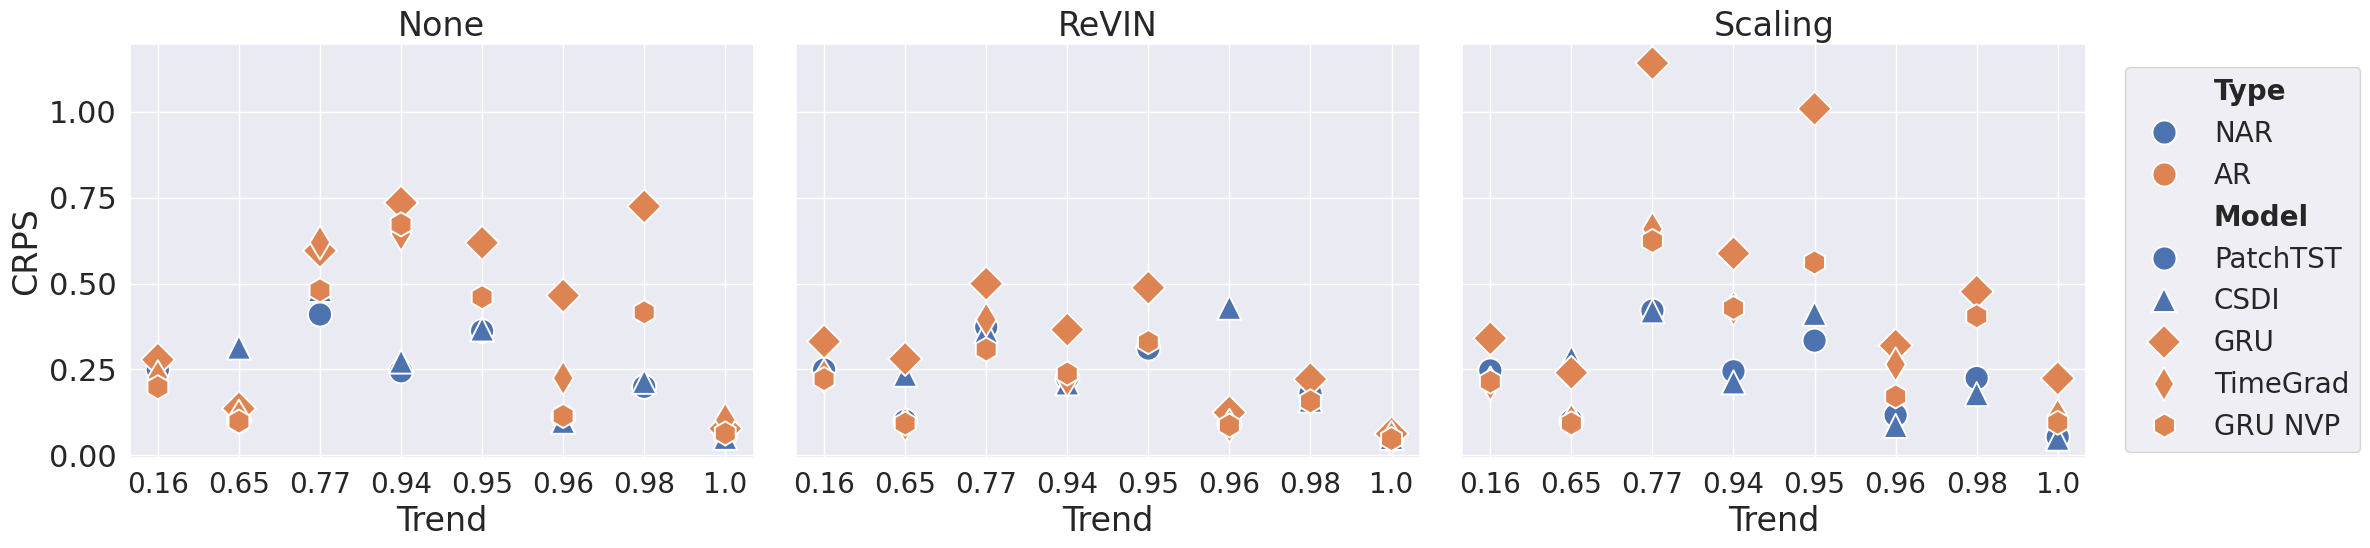

/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])
/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])
/tmp/ipykernel_1227168/3673720674.py:86: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  g = sns.scatterplot(data=none_gap_dict, x=ch, y=metric, hue="Type", markers=model_markers, style="Model",s=300, ax=axes[idx])


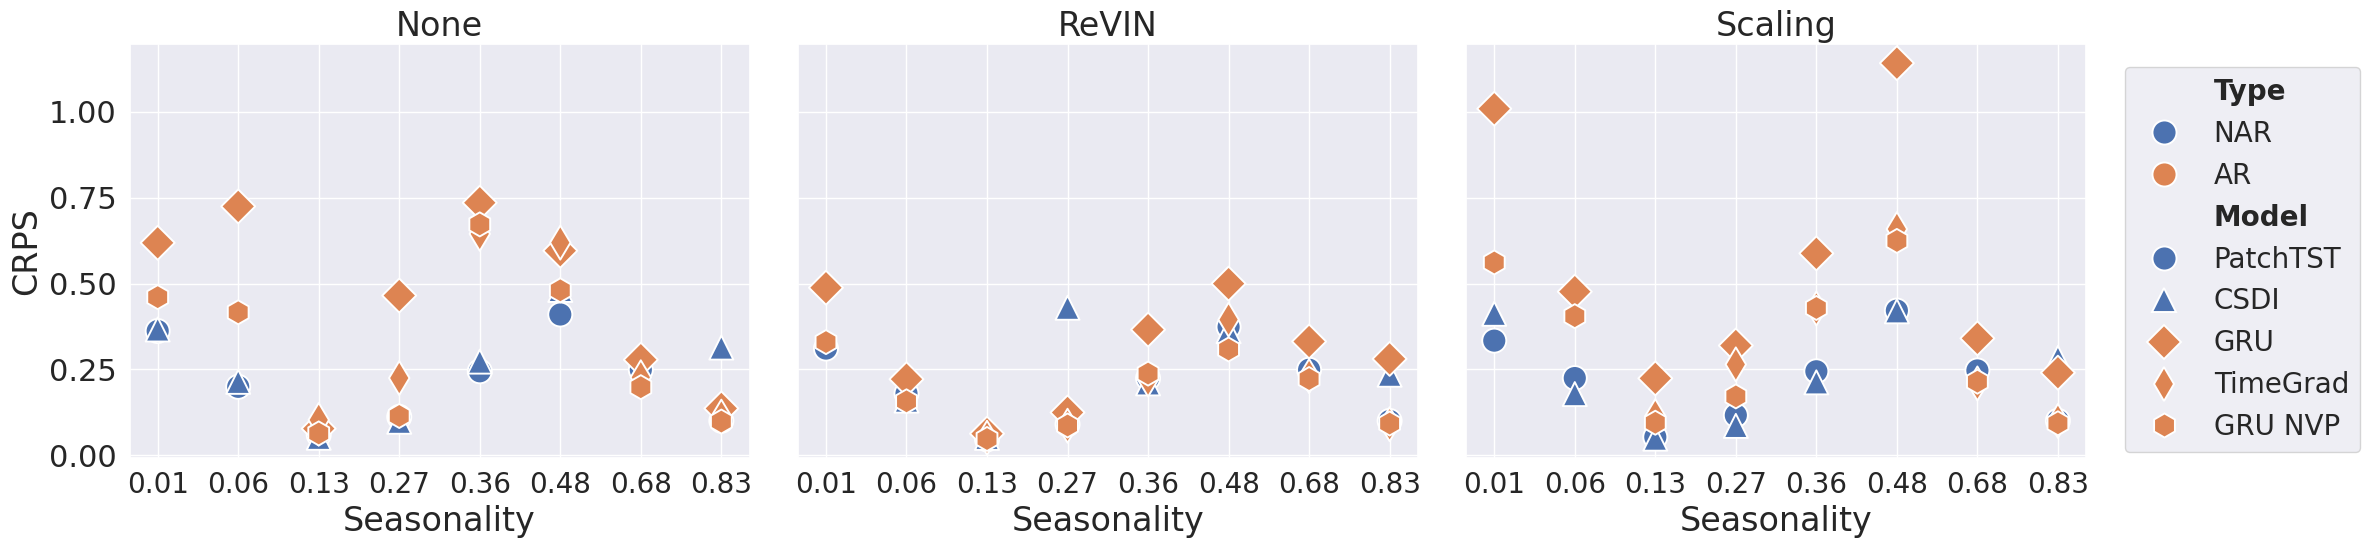

In [44]:
# revin_norm_res = sort_norm_res[sort_norm_res['dataset']!='Electricity']
plot_multi_trend_scatter(sort_norm_res, max_y=0.62, width=8, hight=6, title=None, target_hor=336, norms=['None','ReVIN','Scaling'],ch='Trend',labelsize=20,metric='CRPS')
plot_multi_trend_scatter(sort_norm_res, max_y=0.62, width=8, hight=6, title=None, target_hor=336, norms=['None','ReVIN','Scaling'],ch='Seasonality',labelsize=20,metric='CRPS')

### horizons

In [47]:
def plot_multidata_scatter(gap_dict, width=6, hight=6, datasets=['Weather'], title=None):
    dataset_num = len(datasets)
    ratios = [1] * dataset_num
    # ratios.append(1.5)
    
    width = width * sum(ratios)
    # fig, (ax11, ax12, ax21, ax22) = plt.subplots(1, 4, figsize=(22, 6), gridspec_kw={'width_ratios':[1,1,0.4,1.6]})  # 调整大小
    fig, axes = plt.subplots(1, dataset_num, figsize=(width, hight), gridspec_kw={'width_ratios':ratios})  # 调整大小

    model_markers = ['o', '^', 'D', 'd', 'h', 'X', 'P'] 

    for idx, dataset in enumerate(datasets):
        hor_res = gap_dict[gap_dict['dataset']==dataset]

        sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
                        style="Model", s=300, palette=custom_palette, ax=axes[idx])
        axes[idx].legend().remove()
        axes[idx].set_title(dataset)  
        if idx > 0:
            axes[idx].set_ylabel('')

    hdls, labels = plt.gca().get_legend_handles_labels()
    for i in range(4, 6):
        hdls[i].set_markerfacecolor(custom_palette['NAR'])
    for i in range(6, 9):
        hdls[i].set_markerfacecolor(custom_palette['AR'])

    legend = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.48), fontsize=20)
    for t in legend.get_texts():
        if t.get_text() in ['Type', 'Model']:
            t.set_weight('bold')
    # legend.get_frame().set_facecolor('white')

    # 保存图像
    # plt.savefig('./fig/crps_horizon_and_trend_0814.pdf', bbox_inches='tight')

    if title is not None:
        # plt.title(title)
        # fig.suptitle(title, fontsize=24)
        fig.suptitle(title)
    
    plt.tight_layout() 
    # 显示图像
    plt.show()

/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The

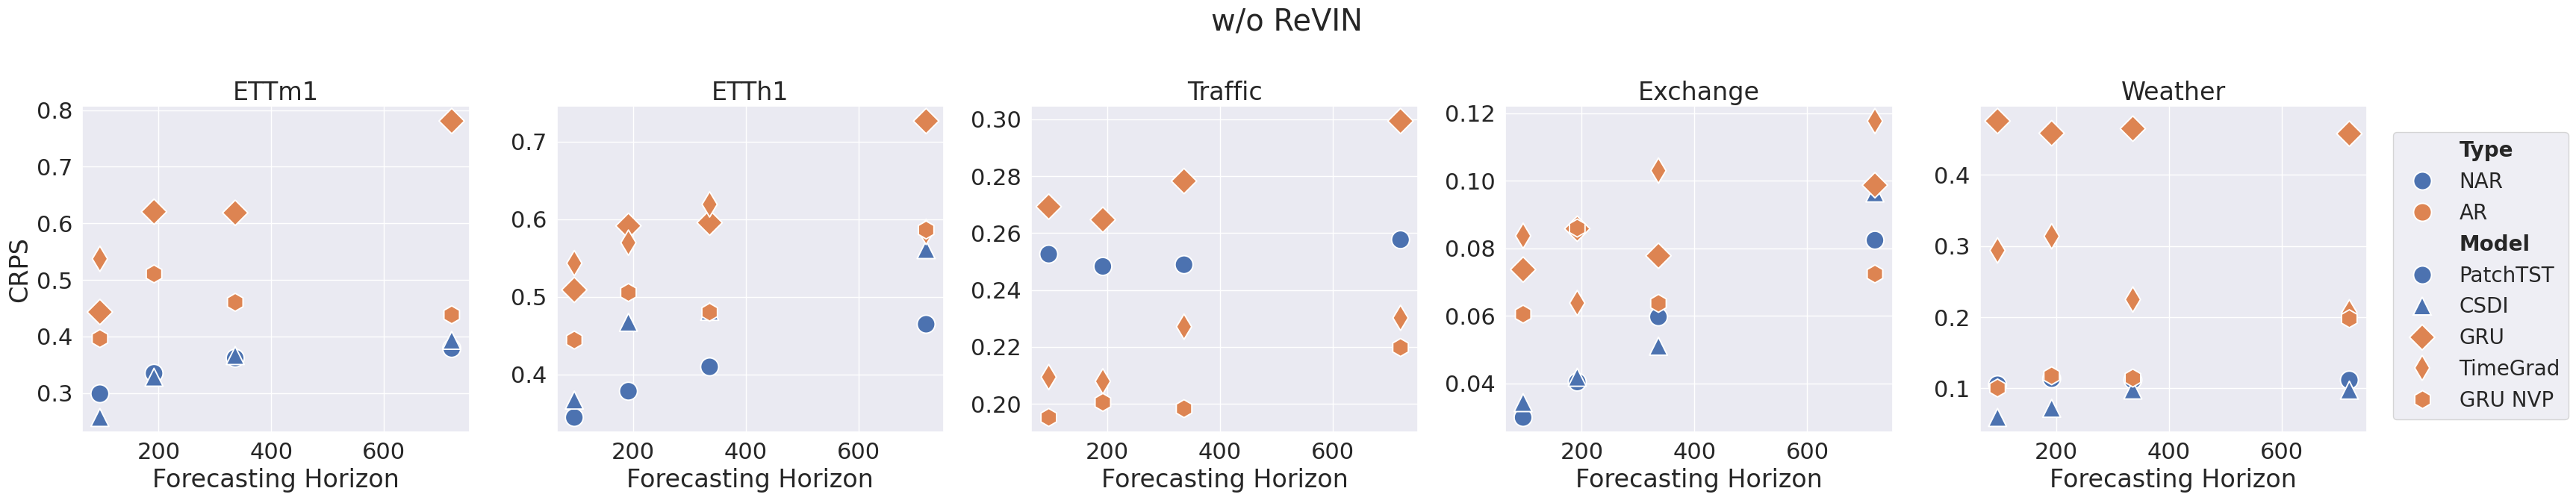

/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The markers list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=hor_res, x='Forecasting Horizon', y='CRPS', hue="Type", markers=model_markers,
/tmp/ipykernel_1227168/922489409.py:15: UserWarning: The

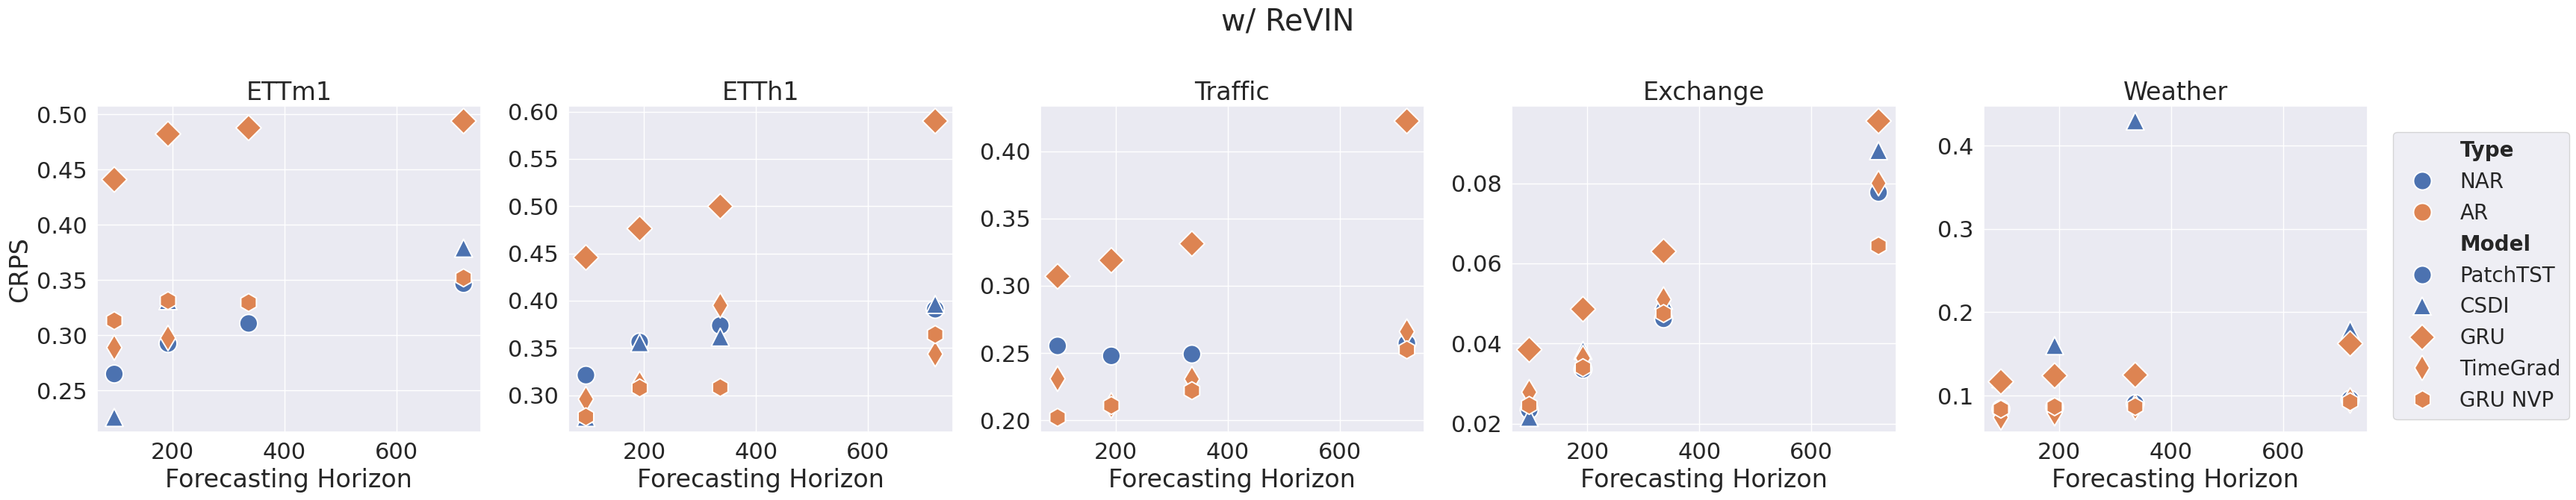

In [48]:
none_norm_res = sort_norm_res[sort_norm_res['norm']=='None']
plot_multidata_scatter(none_norm_res, datasets=['ETTm1', 'ETTh1','Traffic', 'Exchange', 'Weather'], title='w/o ReVIN',width=7, hight=7)

revin_norm_res = sort_norm_res[sort_norm_res['norm']=='ReVIN']
plot_multidata_scatter(revin_norm_res, datasets=['ETTm1','ETTh1','Traffic', 'Exchange', 'Weather'], title='w/ ReVIN',width=7, hight=7)

## short

In [13]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_false/logs/"
norm_false_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_false_res['norm'] = 'None'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_true/logs/"
norm_true_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_true_res['norm'] = 'ReVIN'

root_dir = "/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_revin/norm_temp/logs/"
norm_temp_res = load_result(root_dir=root_dir, verbose=False, models=['GRU_NVP', 'PatchTST'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
norm_temp_res['norm'] = 'Scaling'

norm_res= pd.concat([norm_false_res, norm_true_res, norm_temp_res], ignore_index=True)

In [101]:
combined_df = pd.DataFrame()
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips', 'wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']
models = ['PatchTST', 'CSDI', 'GRU_NVP', 'TimeGrad']
for scaler in ['identity', 'standard']:
    for revin in ['true', 'false']:
        for scaling in ['false', 'true']:
            norm_res = load_result(root_dir = f"/home/v-zhangjiaw/Blob_WestJP/v-jiawezhang/log/abl_norm/{scaler}_revin_{revin}_scaling_{scaling}/logs/", verbose=False, models=models, datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
            norm_res['scaler'] = scaler
            norm_res['revin'] = revin
            norm_res['scaling'] = scaling
            combined_df = pd.concat([combined_df, norm_res], ignore_index=True)
            
            
combined_df['model'] = combined_df['model'].replace('GRU_NVP', 'GRU NVP')

In [128]:
norm_res = reformat(combined_df)
norm_res = replace_dataset_name(norm_res)

sort_order_dict = {'model': ['PatchTST', 'CSDI','GRU', 'TimeGrad', 'GRU NVP'], 'norm': ['ReVIN', 'Scaling','None']}
sort_norm_res = sort_order(norm_res, sort_order_dict=sort_order_dict)
sort_norm_res['ND'] = sort_norm_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_norm_res['CRPS'] = sort_norm_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [129]:
# sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='standard']
# sort_norm_res = sort_norm_res[sort_norm_res["gobal norm"]=='identity']

condition1 = (sort_norm_res['model'].isin(['PatchTST', 'CSDI'])) & (sort_norm_res["gobal norm"] == 'standard')

# 筛选出 model 为 C 且 global 为 identity 的数据
condition2 = (sort_norm_res['model'].isin(['TimeGrad', 'GRU NVP','GRU'])) & (sort_norm_res["gobal norm"] == 'identity')

# 合并两个条件
filtered_df = sort_norm_res[condition1 | condition2]

In [141]:
pivot_table = pd.pivot_table(
    filtered_df,
    values=['CRPS'],
    index=['dataset'],
    columns=['model', 'norm'],
    # columns=['norm'],
    aggfunc=lambda x: x.iloc[0]
)
# pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
# pivot_table = pivot_table.reset_index()
# pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_1490419/3930553219.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [142]:
pivot_table

CRPS                                                                                         
model         PatchTST                    CSDI                 TimeGrad                 GRU NVP                
norm             ReVIN Scaling    None   ReVIN Scaling    None    ReVIN Scaling    None   ReVIN Scaling    None
dataset                                                                                                        
Electricity     0.0717  0.0784  0.0739  0.0524     nan  0.0502   0.0673  0.0563  0.9681  0.0659  0.0706  0.1607
Exchange Rate   0.0100  0.0109  0.0121  0.0070  0.0083  0.0110   0.0100  0.0093  0.0170  0.0090  0.0147  0.0133
Solar           0.6223  0.7577  0.7606  0.4903  0.4347  0.4603   0.4945  0.5455  0.8356  0.9293  0.5926  0.4393
Traffic         0.2079  0.2136  0.2246  0.1505  0.1552  0.1389   0.1806  0.1280  0.1400  0.1827  0.1770  0.2277
Wikipedia       0.2547  0.3335  0.3740  0.2164  0.2060  0.2276   0.2757  0.2773  0.9969  0.3317  0.3187  0.4561

In [ ]:
# print(pivot_table_formatted_md)

In [138]:
latex_code = pivot_table.to_latex(multicolumn=True, multirow=True)

In [133]:
mark_best_value(latex_code)

\begin{tabular}{lllllllllllll}
\toprule
 & \multicolumn{12}{r}{CRPS} \\
model & \multicolumn{3}{r}{PatchTST} & \multicolumn{3}{r}{CSDI} & \multicolumn{3}{r}{TimeGrad} & \multicolumn{3}{r}{GRU NVP} \\
norm & ReVIN & Scaling & None & ReVIN & Scaling & None & ReVIN & Scaling & None & ReVIN & Scaling & None \\
dataset &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Electricity  &  0.0717  &  $\bm{0.0717}$ &  $0.0784$ &  $0.0739$ &  $0.0524$ &  $\underline{\bm{0.0502}}$ &  $0.0673$ &  $\bm{0.0563}$ &  $0.9681$ &  $0.0659$ &  $\bm{0.0706}$ &  $0.1607$ \\ 
Exchange Rate  &  0.0100  &  $\bm{0.0100}$ &  $0.0109$ &  $0.0121$ &  $\underline{\bm{0.0070}}$ &  $0.0083$ &  $0.0110$ &  $0.0100$ &  $\bm{0.0093}$ &  $0.0170$ &  $\bm{0.0090}$ &  $0.0147$ &  $0.0133$ \\ 
Solar  &  0.6223  &  $\bm{0.6223}$ &  $0.7577$ &  $0.7606$ &  $0.4903$ &  $\underline{\bm{0.4347}}$ &  $0.4603$ &  $\bm{0.4945}$ &  $0.5455$ &  $0.8356$ &  $0.9293$ &  $0.5926$ &  $\bm{0.4393}$ \\ 
Traffic  &  0.2079  &  $\bm{0.2079}$ &  

In [139]:
mark_best_value(latex_code)

\begin{tabular}{lllllllllllll}
\toprule
 & \multicolumn{12}{r}{ND} \\
model & \multicolumn{3}{r}{PatchTST} & \multicolumn{3}{r}{CSDI} & \multicolumn{3}{r}{TimeGrad} & \multicolumn{3}{r}{GRU NVP} \\
norm & ReVIN & Scaling & None & ReVIN & Scaling & None & ReVIN & Scaling & None & ReVIN & Scaling & None \\
dataset &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Electricity  &  0.0717  &  $\bm{0.0717}$ &  $0.0784$ &  $0.0739$ &  $0.0666$ &  $\underline{\bm{0.0648}}$ &  $0.0852$ &  $\bm{0.0710}$ &  $0.9742$ &  $0.0861$ &  $\bm{0.0929}$ &  $0.2246$ \\ 
Exchange Rate  &  0.0100  &  $\bm{0.0100}$ &  $0.0109$ &  $0.0121$ &  $\underline{\bm{0.0096}}$ &  $0.0111$ &  $0.0151$ &  $\bm{0.0115}$ &  $0.0118$ &  $0.0220$ &  $\bm{0.0114}$ &  $0.0189$ &  $0.0170$ \\ 
Solar  &  0.6223  &  $\bm{0.6223}$ &  $0.7577$ &  $0.7606$ &  $0.5988$ &  $\underline{\bm{0.5616}}$ &  $0.5680$ &  $\bm{0.6041}$ &  $0.7011$ &  $0.9162$ &  $1.1931$ &  $0.7424$ &  $\bm{0.5893}$ \\ 
Traffic  &  0.2079  &  $\bm{0.2079}$ &  $0

# Channel

In [9]:
datasets=None
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [10]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)
sort_order_dict = {'pred hor.': ['96','192','336','720']}
sort_chennel_res = sort_order(chennel_res, sort_order_dict=sort_order_dict)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [11]:
# Create a pivot table
pivot_table = pd.pivot_table(
    sort_chennel_res,
    values=['CRPS'],
    index=['dataset', 'pred hor.'],
    columns=['model', 'channel'],
    aggfunc=lambda x: x.iloc[0]
)
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table = pivot_table.reset_index()
pivot_table_formatted_md = pivot_table.to_markdown()

/tmp/ipykernel_3845555/372056143.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


In [12]:
print(pivot_table_formatted_md)

|    | dataset     |   pred hor. |   CRPS_DLinear_dep |   CRPS_DLinear_indep |   CRPS_PatchTST_dep |   CRPS_PatchTST_indep |
|---:|:------------|------------:|-------------------:|---------------------:|--------------------:|----------------------:|
|  0 | ETTh1       |          96 |             0.3334 |               0.329  |              0.3239 |                0.3212 |
|  1 | ETTh1       |         192 |             0.3611 |               0.4096 |              0.3609 |                0.3562 |
|  2 | ETTh1       |         336 |             0.3918 |               0.4177 |              0.3763 |                0.3737 |
|  3 | ETTh1       |         720 |             0.4266 |               0.4674 |              0.3882 |                0.3909 |
|  4 | ETTh2       |          96 |             0.3127 |               0.2034 |              0.1731 |                0.1746 |
|  5 | ETTh2       |         192 |             0.3351 |               0.2701 |              0.2001 |                0.2011 |


## short

In [33]:
datasets=['electricity_nips', 'solar_nips', 'exchange_rate_nips','traffic_nips','wiki2000_nips']
train_pred_len_list = ['24', '30']
train_context_list = ['24', '30']

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_false/logs/"
indep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
indep_res['channel'] = 'indep'

root_dir = "/data/Blob_WestJP/v-jiawezhang/log/abl_channel/ch_dep_true/logs/"
dep_res = load_result(root_dir=root_dir, verbose=False, models=['DLinear', 'PatchTST'], datasets=datasets) 
dep_res['channel'] = 'dep'

In [ ]:
chennel_res= pd.concat([dep_res,indep_res], ignore_index=True)
chennel_res = replace_dataset_name(chennel_res)

sort_chennel_res['ND'] = sort_chennel_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
sort_chennel_res['CRPS'] = sort_chennel_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

# Missing baselines - LSTM

In [33]:
train_pred_len_list=['96', '192', '336', '720', '24','36','48','60']
train_context_list=['96', '36']

datasets=['ettm1','etth1','exchange_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline/logs/"
gru_res1 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res1 = replace_dataset_name(gru_res1)

datasets=['ettm2','etth2','weather_ltsf']
root_dir = "/data/Blob_WestJP/v-jiawezhang/log/nn_baseline_scale/logs/"
gru_res2 = load_result(root_dir=root_dir, verbose=False, models=['GRUForecaster'], datasets=datasets, train_pred_len_list=train_pred_len_list, train_context_list=train_context_list) 
gru_res2 = replace_dataset_name(gru_res2)

gru_res = pd.concat([gru_res1, gru_res2], ignore_index=True)

long_crps = pd.read_csv("./exp_res/long_crps.csv")
long_nmae = pd.read_csv("./exp_res/long_nmae.csv")

In [34]:
new_res = gru_res.rename(columns={'dataset': 'Model', 'pred hor.': 'pred_len'})
new_res['pred_len'] = new_res['pred_len'].astype(str)

new_res['ND'] = new_res.apply(lambda x: f"{x['ND']:.4f}", axis=1)
new_res['CRPS'] = new_res.apply(lambda x: f"{x['CRPS']:.4f}", axis=1)

In [35]:
df_merged_nmae = long_nmae.copy()
df_merged_nmae['pred_len'] = df_merged_nmae['pred_len'].astype(str)

df_merged_crps = long_crps.copy()
df_merged_crps['pred_len'] = df_merged_crps['pred_len'].astype(str)


df_merged_crps = df_merged_crps.set_index(['Model', 'pred_len'])
df_merged_nmae = df_merged_nmae.set_index(['Model', 'pred_len'])
new_res = new_res.set_index(['Model', 'pred_len'])

In [36]:
combine_nmae_res = pd.merge(df_merged_nmae, new_res['ND'], left_index=True, right_index=True)
combine_nmae_res = combine_nmae_res.rename(columns={'ND': 'GRU'}).reset_index()

combine_crps_res = pd.merge(df_merged_crps, new_res['CRPS'], left_index=True, right_index=True)
combine_crps_res = combine_crps_res.rename(columns={'CRPS': 'GRU'}).reset_index()

In [37]:
combine_nmae_res.to_csv("./exp_res/update_long_nmae.csv", index=False)
combine_crps_res.to_csv("./exp_res/update_long_crps.csv", index=False)

# Computation Cost

In [2]:
def load_summary(root_dir, verbose=True, models=['ElasTST'], train_pred_len_list=['96-192-336-720'],train_context_list=['96'],datasets=None):
    dataset_list = []
    param_list = []
    mem_list = []
    train_time_list = []
    model_list = []
    if datasets is None:
        datasets = ['ettm1','ettm2','etth1','etth2','exchange_ltsf','weather_ltsf','electricity_ltsf','traffic_ltsf','illness_ltsf']

    seed=0
    
    for dataset in datasets:
        for model in models:
            for train_pred_len in train_pred_len_list:
                for train_context in train_context_list:
                    json_file = root_dir + f"{dataset}_{train_context}_{train_pred_len}_{model}_{seed}/summary.json"
                    
                    try:
                        with open(json_file, 'r') as file:
                            data = json.load(file)
                    except:
                        if verbose:
                            print("cannot find ", json_file) 
                        continue
                    
                    train_time = data['mean_train_batch_time']
                    trainable_parameters = data['trainable_parameters']
                    trainable_parameters_in_mb = trainable_parameters * 4 / (1024 ** 2)
                    train_mem_peak = data['memory_summary']['train']['mem_peak']
                    
                    dataset_list.append(dataset)
                    param_list.append(trainable_parameters_in_mb)
                    mem_list.append(train_mem_peak)
                    train_time_list.append(train_time)
                    model_list.append(model)



    res_dict = {"model":model_list, "dataset": dataset_list, 'NPARAMS (MB)': param_list, 'Max GPU Mem. (GB)': mem_list, "Avg. Train Time": train_time_list}

    return pd.DataFrame(res_dict)

def gpu_dataframe_to_markdown(df, filed='Max GPU Mem. (GB)'):
    # df.loc[:,'model'] = df['model'].replace('TransformerForecaster', 'Transformer', regex=True) 
    df.loc[:, filed] = df[filed].round(4)
    # df = df.pivot_table(index=['dataset'], columns='model', values=filed).reset_index()
    df = df.pivot_table(index=['dataset'], columns='model', values=filed, observed=False).reset_index()
    return df.to_markdown(index=False)

In [3]:
pred_len_list = ['96']
datasets = ['ettm1','electricity_ltsf', 'exchange_ltsf','weather_ltsf','traffic_ltsf']
root_dir = f"/data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/"
comp_budget = load_summary(root_dir, verbose=True, models=['PatchTST','DLinear','TimeGrad','GRU_NVP','CSDI'], train_pred_len_list=pred_len_list, datasets=datasets)

cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/electricity_ltsf_96_96_DLinear_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/weather_ltsf_96_96_CSDI_0/summary.json
cannot find  /data/Blob_WestJP/v-jiawezhang/log/comp_budget/logs/traffic_ltsf_96_96_CSDI_0/summary.json


In [4]:
comp_budget

,model,dataset,NPARAMS (MB),Max GPU Mem. (GB),Avg. Train Time
0,PatchTST,ettm1,5.141750,0.032442,0.029116
1,DLinear,ettm1,0.497341,0.018391,0.016629
2,TimeGrad,ettm1,1.133266,0.028333,0.039893
3,GRU_NVP,ettm1,1.008083,0.025000,0.032739
4,CSDI,ettm1,1.640350,0.147443,0.046746
5,PatchTST,electricity_ltsf,2.047001,0.047467,0.024961
6,TimeGrad,electricity_ltsf,3.310772,0.231849,0.036542
7,GRU_NVP,electricity_ltsf,3.509815,0.140491,0.021862
8,CSDI,electricity_ltsf,1.306679,0.286550,0.050155
9,PatchTST,exchange_ltsf,0.630341,0.018975,0.029638


In [5]:
# gpu_df = replace_dataset_name(combined_gpu_df)
gpu_markdown = gpu_dataframe_to_markdown(comp_budget, filed='Avg. Train Time')

In [6]:
print(gpu_markdown)

| dataset          |     CSDI |   DLinear |   GRU_NVP |   PatchTST |   TimeGrad |
|:-----------------|---------:|----------:|----------:|-----------:|-----------:|
| electricity_ltsf |   0.0502 |  nan      |    0.0219 |     0.025  |     0.0365 |
| ettm1            |   0.0467 |    0.0166 |    0.0327 |     0.0291 |     0.0399 |
| exchange_ltsf    |   0.0482 |    0.0171 |    0.0244 |     0.0296 |     0.0387 |
| traffic_ltsf     | nan      |    0.01   |    0.0358 |     0.0259 |     0.0367 |
| weather_ltsf     | nan      |    0.0094 |    0.0354 |     0.0259 |     0.0427 |
